In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2023-05-13 19:42:18.464851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
df = pd.read_csv('london_merged.csv')

In [120]:
df

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2015-01-04 00:00:00,0.023155,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0,0,1
2015-01-04 01:00:00,0.017557,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0,1,1
2015-01-04 02:00:00,0.017048,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0,2,1
2015-01-04 03:00:00,0.009160,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0,3,1
2015-01-04 04:00:00,0.005980,0.098592,0.1500,0.911950,0.115044,1.0,0.0,1.0,3.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,0.132570,0.183099,0.1750,0.761006,0.336283,3.0,0.0,0.0,3.0,19,1
2017-01-03 20:00:00,0.068830,0.183099,0.1750,0.761006,0.371681,4.0,0.0,0.0,3.0,20,1
2017-01-03 21:00:00,0.042875,0.197183,0.1875,0.729560,0.424779,4.0,0.0,0.0,3.0,21,1


In [22]:
df['timestamp']= pd.to_datetime(df['timestamp'],format="%Y-%m-%d %H:%M:%S")

In [23]:
df.index = df['timestamp']

In [24]:
df.drop('timestamp',axis=1,inplace=True)

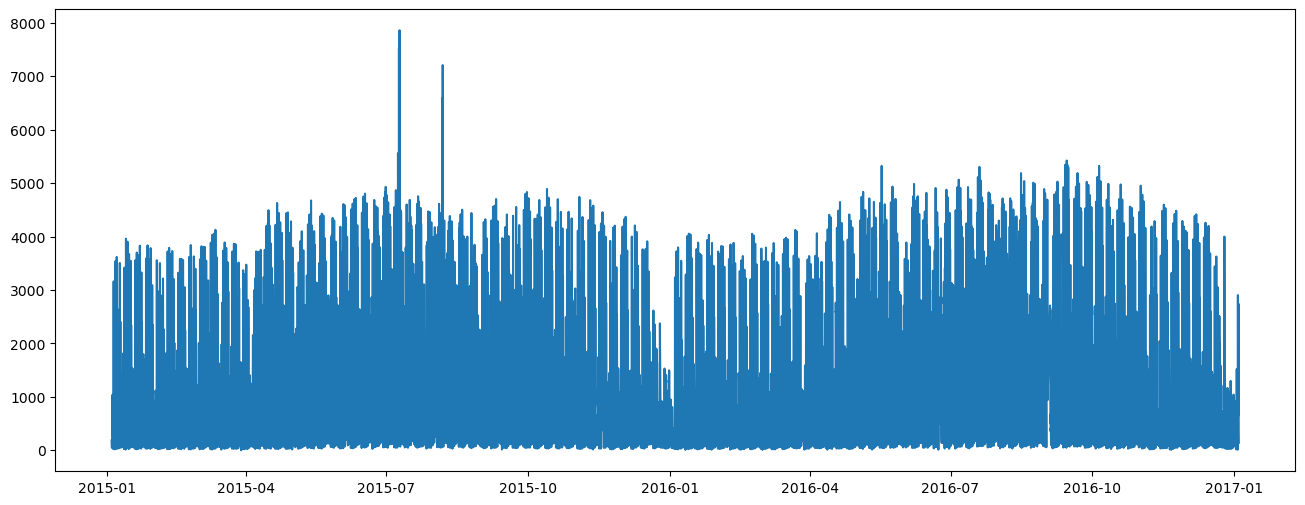

In [54]:
plt.figure(figsize=(16,6))
plt.plot(df.index,df['cnt'],)

In [45]:
df['hour'] = df.index.hour
df['month'] = df.index.month

In [71]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler()
df['t1']=scaler.fit_transform(np.expand_dims(df['t1'],axis=1))
df['t2']=scaler.fit_transform(np.expand_dims(df['t2'],axis=1))
df['hum']=scaler.fit_transform(np.expand_dims(df['hum'],axis=1))
df['wind_speed']=scaler.fit_transform(np.expand_dims(df['wind_speed'],axis=1))
df['cnt']=scaler.fit_transform(np.expand_dims(df['cnt'],axis=1))





In [66]:
np.expand_dims(df['t1'],axis=1).shape

(17414, 1)

In [68]:
df['t1'].values.reshape(-1,1).shape

(17414, 1)

In [88]:
def create_dataset(data,time_step=1):
    Xs = []
    ys =[]
    for i in range (len(data)-time_step):
        Xs.append(data.iloc[i:i+time_step].values)
        ys.append(data['cnt'].iloc[i+time_step])
    
    return np.array(Xs),np.array(ys)

from sklearn.model_selection import train_test_split
time_steps=10
Xs, ys =create_dataset(df,time_steps)
x_train,x_test,y_train,y_test = train_test_split(Xs,ys,test_size=0.1)

In [89]:
batch_size  = 256
buffer_size = 1000


train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test,y_test))

train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = test_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

In [99]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=8,input_shape=(10,11)),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(loss='mae',optimizer='adam')

In [101]:
history = simple_lstm_model.fit(train_data,steps_per_epoch=200,epochs=10,validation_data=test_data,validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 9ms/step - loss: 0.1506 - val_loss: 0.0787
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0698 - val_loss: 0.0652
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0625 - val_loss: 0.0600
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0568 - val_loss: 0.0534
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0505 - val_loss: 0.0476
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0464 - val_loss: 0.0449
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0440 - val_loss: 0.0429
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0422 - val_loss: 0.0410
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0405 - val_loss: 0.0396
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0394 - val_loss: 0.0382

<AxesSubplot:>

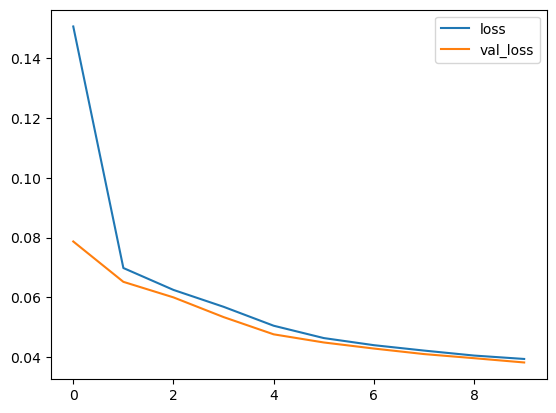

In [105]:
pd.DataFrame(history.history).plot()

In [107]:
X_test,y_test = create_dataset(df,10)

In [108]:
y_pred = simple_lstm_model.predict(X_test)

544/544 [==============================] - 1s 1ms/step


In [110]:
y_pred.shape

(17404, 1)

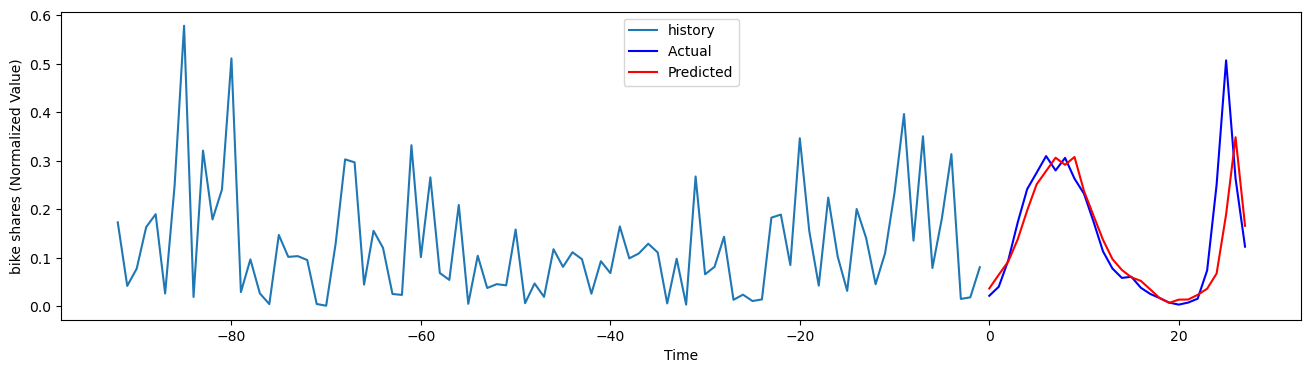

In [118]:
def create_time_steps(length):
    return list(range(-length, 0))
# We then do the plotting using the following code:
plt.figure(figsize = (16,4))
num_in = create_time_steps(92)
num_out = 28
plt.plot(num_in,y_train[15571:],label = 'history')
plt.plot(np.arange(num_out),y_test[15661:15689], 'b',label='Actual ')
plt.plot(np.arange(num_out),y_pred[15661:15689], 'r',label = 'Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()


In [116]:
y_train[15571:].shape

(92,)

In [121]:
np.arange(num_out)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])